<img src="header_anwender.png" align="left"/>

# Anwendungsbeispiel Import of image data with augmentation and classification

Das Ziel dieses Beispieles ist es die Organisation, den Import und die Vorbereitung von Bilddaten für eine Klassifikation zu erklären. Dabei werden folgende Schritte durchgeführt:

- Dynamisches Laden und entpacken der Bilddaten von einer externen Quelle
- Review der Organisation auf dem Filesystem
- Laden der Daten
- Transformationen
- Augmentierung
- Training
- Analyse
- Verbesserung

Der verwendete Datensatz heisst caltech101[3] mit 101 Klassen und jeweils 40 bis 800 Bildern pro Klasse. Die Bilder haben 200 - 300 Pixel Auflösung in Farbe.

Quellen für die Beispiele und Daten:

- [1] [https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- [2] [https://github.com/bhavul/Caltech-101-Object-Classification](https://github.com/bhavul/Caltech-101-Object-Classification)
- [3] [http://www.vision.caltech.edu/Image_Datasets/Caltech101/](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)



In [1]:
#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)



#
# Import der Module
#
import os
import logging
import tarfile
import operator
import random
from urllib.request import urlretrieve
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


#
# Tensorflow und Keras
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#
# Für GPU Support
#
tflogger = tf.get_logger()
tflogger.setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Ausgabe der Versionen
#
print('working on keras version {} on tensorflow {} using sklearn {}'.format ( tf.keras.__version__, tf.version.VERSION, sklearn.__version__ ) )

[]
working on keras version 2.11.0 on tensorflow 2.11.0 using sklearn 1.2.2


# Hilfsfunktionen 

In [2]:
urlDataSource = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
localExtractionFolder = 'data/caltech101'
localDataArchive = 'data/caltech101/caltech101.tar.gz'

In [3]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,dataset_file_path):
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden der Daten

In [4]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localDataArchive)

archive already downloaded.


In [5]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/caltech101/caltech101.tar.gz to data/caltech101 done.


# Organisation von Bilddaten auf dem Filesystem

Eine gute Einführung in das Thema ist zu finden unter

- [Brownlee](https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/) 
- [Sarkar](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)

<img src="info.png" align="left"/> 

# Erzeugen der Trainingsdaten

In [6]:
#
# Hilfsfunktionen
#

def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("data directory not found.")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def return_images_per_category(data_directory):
    folder = os.path.join(data_directory,"101_ObjectCategories")
    #print(folder)
    categories=[d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder,d))]
    #print(categories)
    return categories

#
# Lesen der Bilddaten aus einer Datei. Anpassen der Größe auf 300x200 (Breite x Höhe) Pixel.
#
def read_image(image_path):
    #img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)    
    im = Image.open(image_path).convert("RGB").resize((300,200))
    np_img = np.array(im)
    return np_img


#
# Sammelfunktion die alle Kategorien durchgeht und die Files sammelt
#
def create_training_data(data_directory,fraction):
    
    i = 0
    X = []
    Y = []
    
    print("started to read dataset from {}.".format(data_directory) )
    
    for category in return_images_per_category(data_directory):
        
        if category == 'BACKGROUND_Google':
            continue
        
        print(".",end='')
        
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                continue
                
            if random.uniform(0, 1) > fraction:
                continue
                
            X.insert(i, read_image(image) )
            Y.insert(i, category )
            i += 1
    print("finished reading dataset.")
    X = np.array(X)
    return X,Y

In [7]:
#
# Erzeugen der Trainingsdaten. Der Faktor fraction bestimmt, wieviele Daten wirklich in den Speicher geladen werden.
# Achtung: diese Funktion kümmert sich nicht um die Gleichverteilung der Klassen.
#
X, Y = create_training_data(localExtractionFolder,fraction=0.4)

print('data X={}, y={}'.format(X.shape, len(Y)) )

started to read dataset from data/caltech101.
.....................................................................................................finished reading dataset.
data X=(3433, 200, 300, 3), y=3433


In [8]:
print(Y)

['gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'gerenuk', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'hawksbill', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'headphone', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'ant', 'but

In [9]:
#
# Transformation der Labels in one-hot encoding
#
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_one_hot = to_categorical(Y_integer_encoded)

In [10]:
Y_one_hot.shape

(3433, 101)

In [11]:
#
# Normalisieren der Bilddaten
#
X_normalized = ( X.astype(np.float64) / 255 ) + 0.001


#
# Löschen von X um Speicher gezielt freizumachen
#
del X

In [12]:
#
# Split der Daten in Train und Test(validation) Datensätze
#
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)
del X_normalized


#
# gültige Werte in X_train, X_validation, Y_train, Y_validation, label_encoder, data_directory
#

# Prüfen der Daten

In [32]:
#
# Form der Daten
#
print('train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('test: X=%s, y=%s' % (X_validation.shape, Y_validation.shape))

#
# Plot von Bildern
#
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train: X=(2574, 200, 300, 3), y=(2574, 101)
test: X=(859, 200, 300, 3), y=(859, 101)


# Bauen eines Modelles

In [14]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(101, activation='softmax'))
    return model

In [15]:
#
# Compile und Training des Modelles
#
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [16]:
#
# Callbacks steuern das Speichern von Checkpoints und eine Überwachung gegen Overfitting.
#
callbacks = [ModelCheckpoint('model_cnn_weights.h5', monitor='val_acc', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]

In [17]:
history = model_cnn.fit(X_train, Y_train, batch_size=16, epochs=6, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/6


2023-03-23 18:37:04.099261: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


161/161 [==============================] - 124s 766ms/step - loss: 4.2023 - accuracy: 0.1698 - val_loss: 3.5766 - val_accuracy: 0.2666
Epoch 2/6
161/161 [==============================] - 170s 1s/step - loss: 2.2901 - accuracy: 0.4876 - val_loss: 2.9345 - val_accuracy: 0.4261
Epoch 3/6
161/161 [==============================] - 173s 1s/step - loss: 0.4315 - accuracy: 0.8920 - val_loss: 5.5522 - val_accuracy: 0.4098
Epoch 4/6
161/161 [==============================] - 178s 1s/step - loss: 0.0712 - accuracy: 0.9833 - val_loss: 7.7114 - val_accuracy: 0.4191
Epoch 5/6
161/161 [==============================] - 182s 1s/step - loss: 0.0088 - accuracy: 0.9996 - val_loss: 8.6053 - val_accuracy: 0.4272
Epoch 6/6
161/161 [==============================] - 183s 1s/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 6.5997 - val_accuracy: 0.4296
Epoch 6: early stopping


In [18]:
#
# Evaluierung des Modelles
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.430 


In [19]:
#
# Ausgabe des Trainingsverlaufes
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='lightblue', label='test')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='green', label='train')
    plt.plot(history.history['val_accuracy'], color='lightgreen', label='test')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

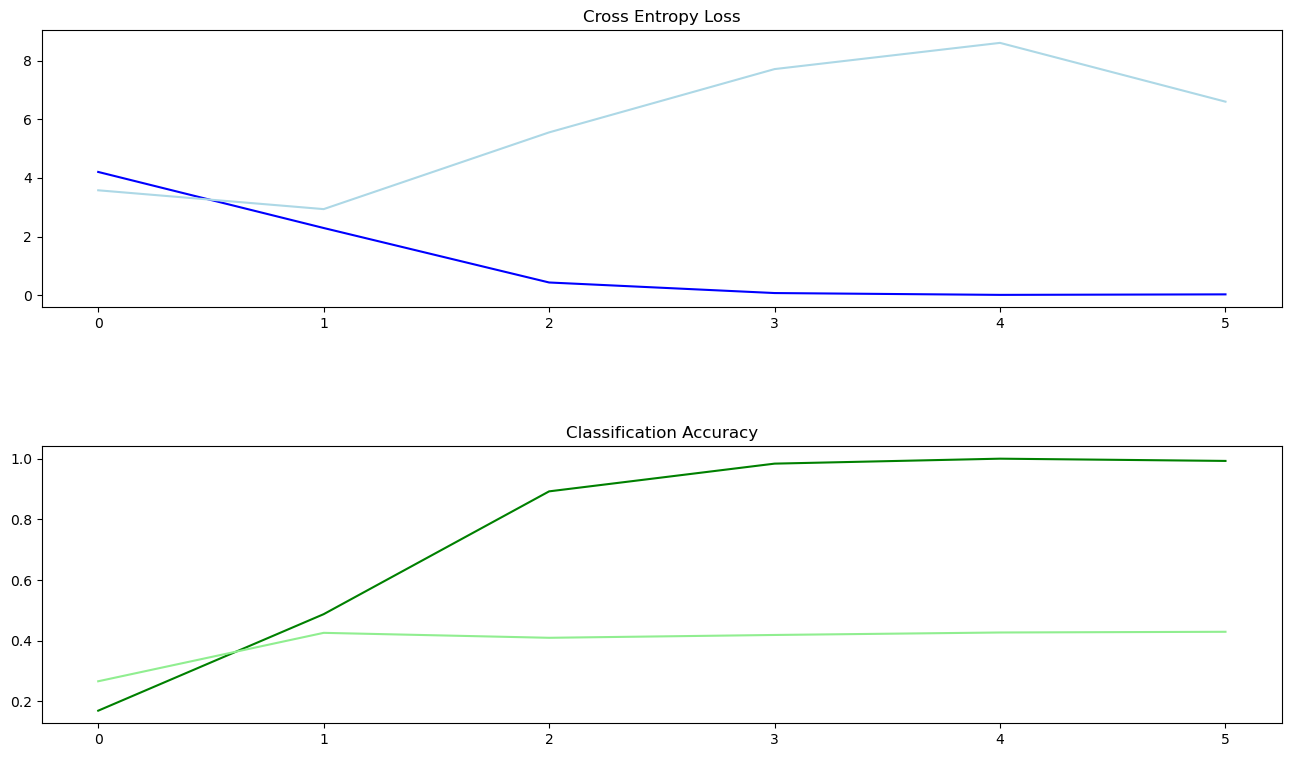

In [20]:
summarize_diagnostics(history,'05_model_cnn')

# Optimiertes Laden der Bilder

Die bisherige Ladefunktion hat alle Bilder in den Speicher geladen. Das führt schnell dazu, dass der Hauptspeicher ausgeht. Daher benötigen wir eine Funktion, die Bilder der Reihe nach in den Speicher lädt und für das Training zur Verfügung stellt.

Eine solche Funktion kann mit einem python **Generator** implementiert werden. Die Erklärung von Generatoren ist hier zu finden [2]. Das Tutorial zum Laden mit Generatoren ist hier [1] zu finden.

Quellen:
- [1] [https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df](https://towardsdatascience.com/a-single-function-to-streamline-image-classification-with-keras-bd04f5cfe6df)
- [2] [https://www.python-kurs.eu/generatoren.php](https://www.python-kurs.eu/generatoren.php)


<img src="info.png" align="left"/> 


In [21]:
#
# Anlegen eines Generators für Bilder
#
datagen = ImageDataGenerator()

In [22]:
it_train = datagen.flow(X_train, Y_train, batch_size=16)

In [23]:
#
# Training
#
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [24]:
#
# Neue Funktion fit_generator
#
steps = int(X_train.shape[0] / 16)
history = model_cnn.fit_generator(it_train, steps_per_epoch=steps, epochs=6, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/6
160/160 [==============================] - 128s 800ms/step - loss: 4.5324 - accuracy: 0.1243 - val_loss: 4.0105 - val_accuracy: 0.1979
Epoch 2/6
160/160 [==============================] - 175s 1s/step - loss: 3.5337 - accuracy: 0.2666 - val_loss: 3.3773 - val_accuracy: 0.3132
Epoch 3/6
160/160 [==============================] - 190s 1s/step - loss: 2.8111 - accuracy: 0.3929 - val_loss: 3.2414 - val_accuracy: 0.3644
Epoch 4/6
160/160 [==============================] - 211s 1s/step - loss: 2.2930 - accuracy: 0.4824 - val_loss: 3.2222 - val_accuracy: 0.3586
Epoch 5/6
160/160 [==============================] - 195s 1s/step - loss: 1.3452 - accuracy: 0.6927 - val_loss: 3.7631 - val_accuracy: 0.3702
Epoch 6/6
160/160 [==============================] - 194s 1s/step - loss: 0.4831 - accuracy: 0.8784 - val_loss: 4.5942 - val_accuracy: 0.3737


accuracy 0.374 


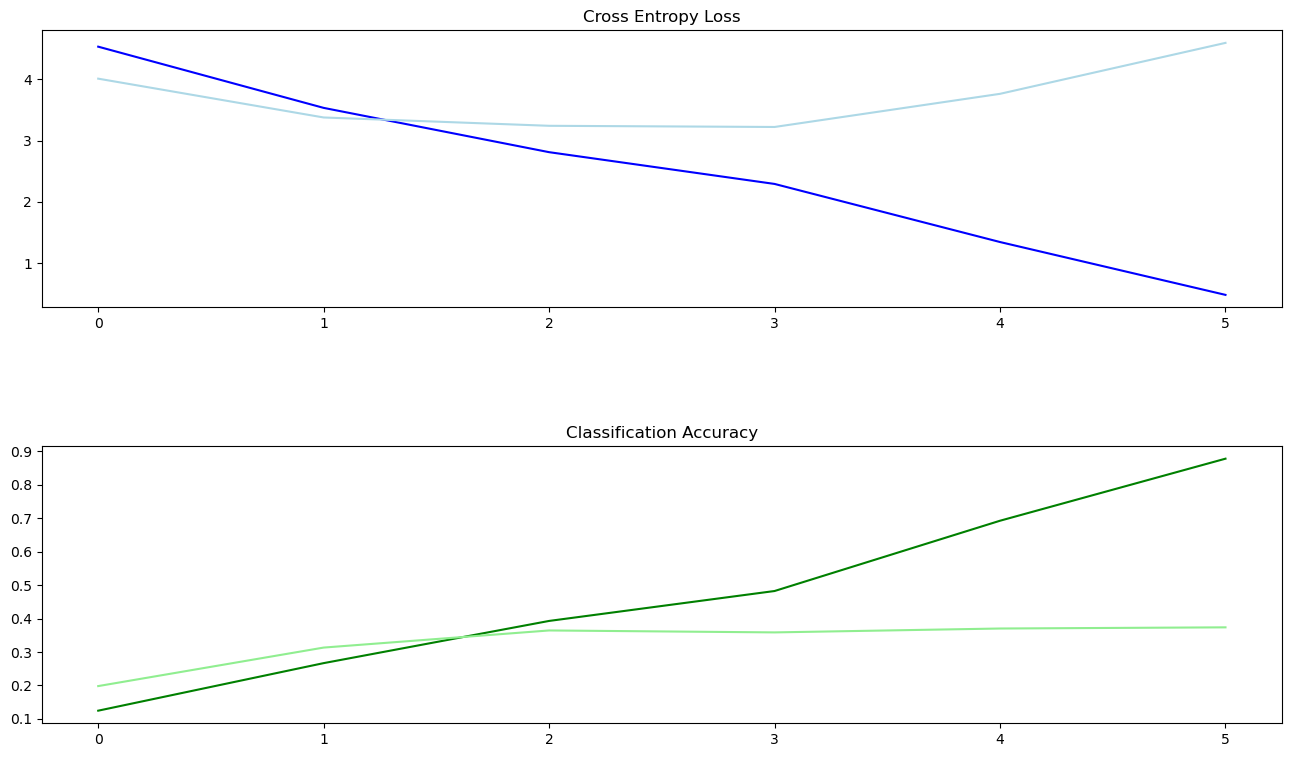

In [25]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )
summarize_diagnostics(history,'model_cnn_gen')

# Optimierung durch Augmentierung

Augmentierung erweitert den Trainingsdatensatz um künstlich erzeugte Bilder. Damit wird erreicht, dass ein Modell robuster wird und sich nicht auf einzelne Pixel bezieht. Methoden der Augmentierung für Bilder sind:

- Breite und Höhe des Bildinhaltes ändern (width_shift_range, height_shift_range)
- Spiegelung (flip)
- Rotation (rotation_range)
- Zoomen (zoom_range)
- Helligkeit (brightness_range)
- Verzerrung (shear_range)

Das Zufügen von Rauschen kann in Keras nicht direkt über den [ImageDataGenerator](https://keras.io/preprocessing/image/) eingestellt werden. Dies wird aber durch die Verwendung von Dropout annähernd simuliert.

<img src="info.png" align="left"/> 


In [26]:
#
# Anlegen eines Generators für Bilder
#
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=5, zoom_range=0.1)
# prepare iterator
it_train = datagen.flow(X_train, Y_train, batch_size=16)

In [27]:
#
# Training
#
steps = int(X_train.shape[0] / 16)

In [28]:
model_cnn = createModel()
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [29]:
history = model_cnn.fit_generator(it_train, steps_per_epoch=steps, epochs=24, validation_data=(X_validation,Y_validation), verbose=1, callbacks=callbacks)

Epoch 1/24
160/160 [==============================] - 188s 1s/step - loss: 4.4183 - accuracy: 0.1400 - val_loss: 4.0096 - val_accuracy: 0.1723
Epoch 2/24
160/160 [==============================] - 193s 1s/step - loss: 3.6738 - accuracy: 0.2428 - val_loss: 3.3908 - val_accuracy: 0.2666
Epoch 3/24
160/160 [==============================] - 209s 1s/step - loss: 3.2696 - accuracy: 0.2955 - val_loss: 3.0807 - val_accuracy: 0.3376
Epoch 4/24
160/160 [==============================] - 217s 1s/step - loss: 3.0547 - accuracy: 0.3339 - val_loss: 3.1056 - val_accuracy: 0.3481
Epoch 5/24
160/160 [==============================] - 199s 1s/step - loss: 2.7822 - accuracy: 0.3843 - val_loss: 2.8360 - val_accuracy: 0.4203
Epoch 6/24
160/160 [==============================] - 206s 1s/step - loss: 2.5847 - accuracy: 0.4093 - val_loss: 2.7633 - val_accuracy: 0.4319
Epoch 7/24
160/160 [==============================] - 211s 1s/step - loss: 2.4458 - accuracy: 0.4394 - val_loss: 2.7409 - val_accuracy: 0.4424

In [30]:
#
# Evaluierung
#
_, acc = model_cnn.evaluate(X_validation, Y_validation, verbose=0)
print('accuracy {:.3f} '.format(acc) )

accuracy 0.510 


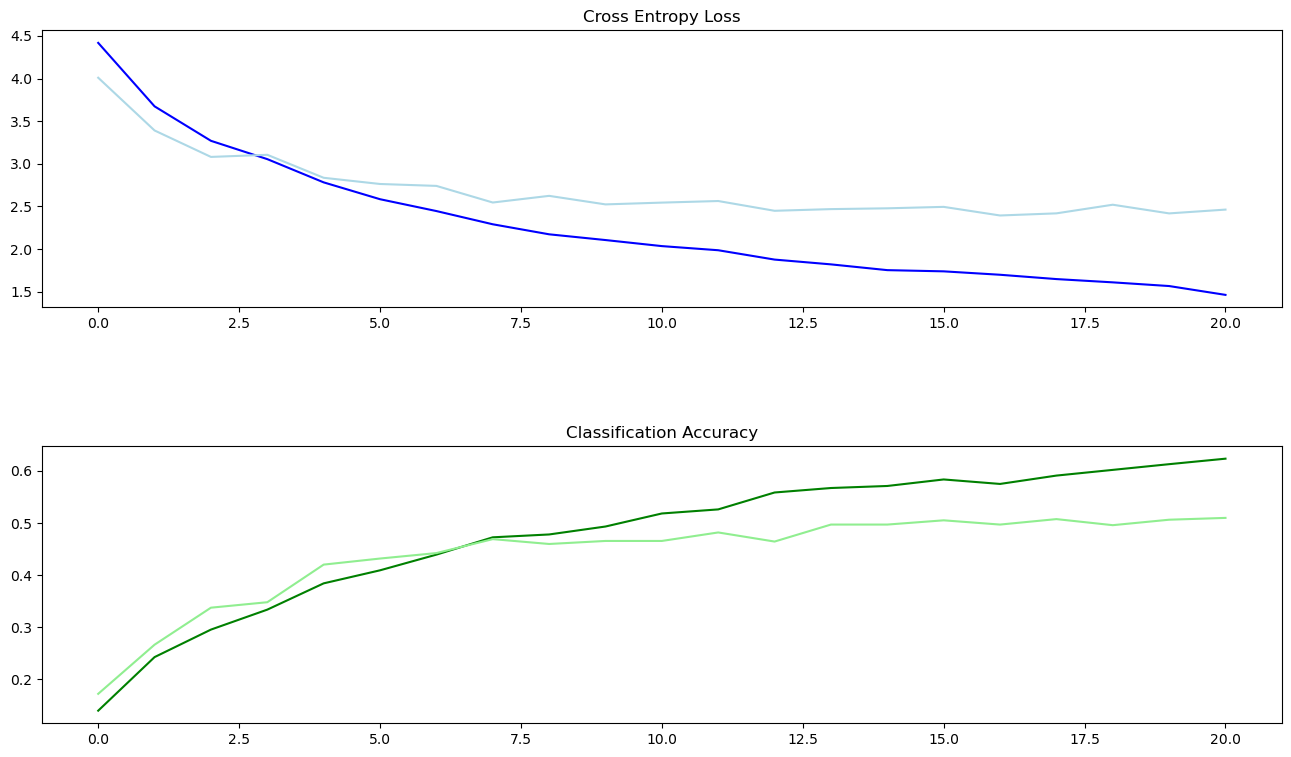

In [31]:
summarize_diagnostics(history,'05_model_cnn_aug')